In [33]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, pulse, transpile, IBMQ
from qiskit.circuit import Gate
from qiskit.tools.monitor import job_monitor

In [2]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-utokyo', group='internal', project='icepp')
backend = provider.get_backend('ibmq_quito')

In [3]:
sched_map = backend.defaults().instruction_schedule_map

In [7]:
sched_map.get('cx', (2, 1)).instructions

((0, ShiftPhase(1.5707963267948966, DriveChannel(2))),
 (0, ShiftPhase(1.5707963267948966, ControlChannel(2))),
 (0,
  Play(Drag(duration=160, amp=(0.0689741022036582+0.0012892058403897587j), sigma=40, beta=-0.998507644250899, name='X90p_d1'), DriveChannel(1), name='X90p_d1')),
 (0,
  Play(Drag(duration=160, amp=(-3.235772595044295e-17-0.17614725580726168j), sigma=40, beta=0.007790270528855921, name='Ym_d2'), DriveChannel(2), name='Ym_d2')),
 (160,
  Play(GaussianSquare(duration=432, amp=(0.06498263148017643-0.0007792115631971719j), sigma=64, width=176, name='CR90p_d1_u4'), DriveChannel(1), name='CR90p_d1_u4')),
 (160,
  Play(GaussianSquare(duration=432, amp=(0.35219851932509716-0.44747080118494786j), sigma=64, width=176, name='CR90p_u4'), ControlChannel(4), name='CR90p_u4')),
 (592,
  Play(Drag(duration=160, amp=(0.17614725580726168+0j), sigma=40, beta=0.007790270528855921, name='Xp_d2'), DriveChannel(2), name='Xp_d2')),
 (752,
  Play(GaussianSquare(duration=432, amp=(-0.0649826314801

In [35]:
circuits = []

for width in range(0, 700, 32):
    with pulse.build(backend=backend, default_alignment='sequential', name='crosstalk') as sched:
        pulse.play(pulse.GaussianSquare(duration=(256 + width), amp=(0.35219851932509716-0.44747080118494786j), sigma=64, width=width, name='CR90p_u4'), pulse.ControlChannel(4), name='CR90p_u4')
        
    cr_gate = Gate('cr', 2, [])

    circuit = QuantumCircuit(2)
    circuit.append(cr_gate, (0, 1))

    circuit.add_calibration('cr', (2, 1), sched)

    circuit_x = circuit.copy()
    circuit_x.h(1)
    circuit_x.measure_all()
    circuits.append(circuit_x)

    circuit_y = circuit.copy()
    circuit_y.sdg(1)
    circuit_y.h(1)
    circuit_y.measure_all()
    circuits.append(circuit_y)

    circuit_z = circuit.copy()
    circuit_z.measure_all()
    circuits.append(circuit_z)

circuits = transpile(circuits, backend=backend, initial_layout=[2, 1])

In [36]:
len(circuits)

66

In [37]:
job = backend.run(circuits, shots=2000)
job_monitor(job)

Job Status: job has successfully run


In [38]:
counts = job.result().get_counts()

In [39]:
len(counts)

66

In [77]:
job = backend.retrieve_job('6201ce4b069bb275050fae8c')
data = np.empty((len(circuits), 4), dtype='f8')
for ires, res in enumerate(job.result().results):
#    data[ires] = 2. * ((res.data.counts.get('0x0', 0) + res.data.counts.get('0x1', 0)) / sum(res.data.counts.values())) - 1.
    data[ires, 0] = res.data.counts.get('0x0', 0)
    data[ires, 1] = res.data.counts.get('0x1', 0)
    data[ires, 2] = res.data.counts.get('0x2', 0)
    data[ires, 3] = res.data.counts.get('0x3', 0)
    

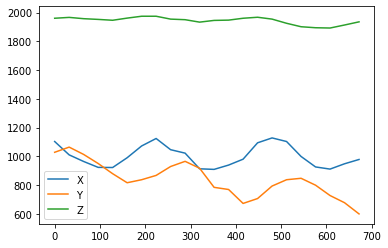

In [78]:
w = np.arange(0, 700, 32)
plt.plot(w, data[::3, 0], label='X')
plt.plot(w, data[1::3, 0], label='Y')
plt.plot(w, data[2::3, 0], label='Z')
plt.legend();

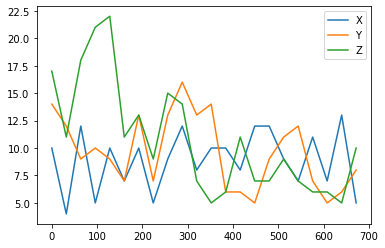

In [79]:
w = np.arange(0, 700, 32)
plt.plot(w, data[::3, 1], label='X')
plt.plot(w, data[1::3, 1], label='Y')
plt.plot(w, data[2::3, 1], label='Z')
plt.legend();

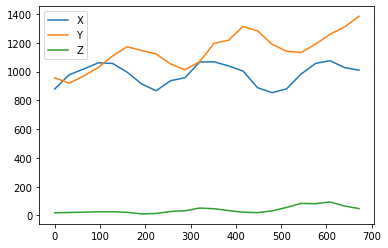

In [80]:
w = np.arange(0, 700, 32)
plt.plot(w, data[::3, 2], label='X')
plt.plot(w, data[1::3, 2], label='Y')
plt.plot(w, data[2::3, 2], label='Z')
plt.legend();

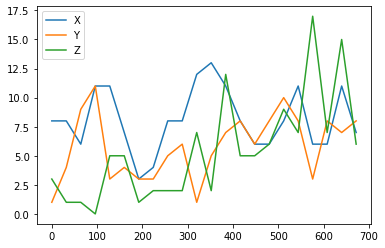

In [81]:
w = np.arange(0, 700, 32)
plt.plot(w, data[::3, 3], label='X')
plt.plot(w, data[1::3, 3], label='Y')
plt.plot(w, data[2::3, 3], label='Z')
plt.legend();

In [53]:
circuits = []

for width in range(0, 700, 32):
    with pulse.build(backend=backend, default_alignment='sequential', name='crosstalk') as sched:
        pulse.play(pulse.GaussianSquare(duration=(256 + width), amp=(0.35219851932509716-0.44747080118494786j), sigma=64, width=width, name='CR90p_u4'), pulse.DriveChannel(1), name='CR90p_u4')
        
    cr_gate = Gate('cr', 1, [])

    circuit = QuantumCircuit(2)
    circuit.append(cr_gate, (1,))

    circuit.add_calibration('cr', (1,), sched)

    circuit_x = circuit.copy()
    circuit_x.h(1)
    circuit_x.measure_all()
    circuits.append(circuit_x)

    circuit_y = circuit.copy()
    circuit_y.sdg(1)
    circuit_y.h(1)
    circuit_y.measure_all()
    circuits.append(circuit_y)

    circuit_z = circuit.copy()
    circuit_z.measure_all()
    circuits.append(circuit_z)

circuits = transpile(circuits, backend=backend, initial_layout=[2, 1])

In [54]:
job = backend.run(circuits, shots=2000)
job_monitor(job)

Job Status: job has successfully run


In [55]:
result = job.result()

In [75]:
job = backend.retrieve_job('6201d0bf069bb213a40fae96')
data_single = np.empty(len(circuits), dtype='f8')
for ires, res in enumerate(job.result().results):
    data_single[ires] = 2. * ((res.data.counts.get('0x0', 0) + res.data.counts.get('0x1', 0)) / sum(res.data.counts.values())) - 1.

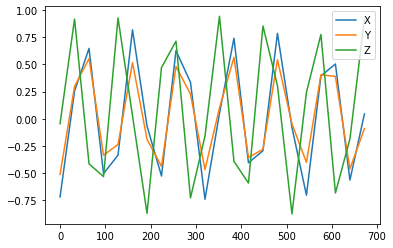

In [76]:
w = np.arange(0, 700, 32)
plt.plot(w, data_single[::3], label='X')
plt.plot(w, data_single[1::3], label='Y')
plt.plot(w, data_single[2::3], label='Z')
plt.legend();

In [82]:
sched_map.get('x', (1,))

Schedule((0, Play(Drag(duration=160, amp=(0.13862624714882676+0j), sigma=40, beta=-0.5243755419832207, name='Xp_d1'), DriveChannel(1), name='Xp_d1')), name="x")

In [84]:
(np.abs(0.35219851932509716-0.44747080118494786j) * 64) / (0.13862624714882676 * 40)

6.572498925110013